In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import warnings
import datetime as dt
import os
import scipy
sns.set_style('dark')
%matplotlib inline
warnings.filterwarnings("ignore")

In [48]:
data = pd.read_csv('./dataset/mozilla_bugs_final.csv')

In [7]:
data.head()

,Bug ID,Type,Summary,Reporter Real Name,Product,Component,Assignee,Status,Resolution,Priority,Classification,Team Name,Filed via
0,1546498,defect,[trunk] Crash on startup (mozilla::ReadAheadLi...,Mark Straver,Firefox,General,dothayer,RESOLVED,FIXED,P1,Client Software,Frontend,unknown
1,1469450,defect,release-update-verify-config tasks failing for...,Jordan Lund (:jlund),Release Engineering,Release Automation: Updates,nrthomas,RESOLVED,FIXED,P1,Other,RelEng,unknown
2,1570570,defect,Android workers not taking jobs.,Bogdan Tara[:bogdan_tara | bogdant],Taskcluster,General,wcosta,RESOLVED,FIXED,P1,Other,Mozilla,unknown
3,1596430,defect,browser/base/content/test/performance/browser_...,Treeherder Bug Filer,NSS,Libraries,jc,RESOLVED,FIXED,P1,Components,Crypto,api
4,1535246,defect,Breakpoint positions are only fetched for some...,Logan Smyth [:loganfsmyth],DevTools,Debugger,loganfsmyth,RESOLVED,INVALID,P1,Components,DevTools,unknown


In [8]:
data.shape #30000 records in total and 13 attributes

(30000, 13)

In [10]:
data.info() #listing down initial attributes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Bug ID              30000 non-null  int64 
 1   Type                30000 non-null  object
 2   Summary             30000 non-null  object
 3   Reporter Real Name  28882 non-null  object
 4   Product             30000 non-null  object
 5   Component           30000 non-null  object
 6   Assignee            30000 non-null  object
 7   Status              30000 non-null  object
 8   Resolution          30000 non-null  object
 9   Priority            30000 non-null  object
 10  Classification      30000 non-null  object
 11  Team Name           30000 non-null  object
 12  Filed via           30000 non-null  object
dtypes: int64(1), object(12)
memory usage: 3.0+ MB


In [11]:
data.isna().any() #Reporter Real Name has some null values

Bug ID                False
Type                  False
Summary               False
Reporter Real Name     True
Product               False
Component             False
Assignee              False
Status                False
Resolution            False
Priority              False
Classification        False
Team Name             False
Filed via             False
dtype: bool

In [12]:
# There are no duplicate values
data[data.duplicated()]

,Bug ID,Type,Summary,Reporter Real Name,Product,Component,Assignee,Status,Resolution,Priority,Classification,Team Name,Filed via


In [13]:
data.columns #13 columns in total

Index(['Bug ID', 'Type', 'Summary', 'Reporter Real Name', 'Product',
       'Component', 'Assignee', 'Status', 'Resolution', 'Priority',
       'Classification', 'Team Name', 'Filed via'],
      dtype='object')

## Exploratory Data Analysis To Determine Useful features and Eliminate those that are not necessary for our use case

In [14]:
len(data['Bug ID'].unique()) #Bug ID - No bug ids are repeated. All unique bugs and no repeated records during updates

30000

In [15]:
data.Type.unique() #Category of issues - Enhancements, Defect and Tasks

array(['defect', 'task', 'enhancement'], dtype=object)

In [16]:
data[data.Type=='defect'].shape #12415 records out of 30000 are defects. Rest are enhancements and new tasks

(12415, 13)

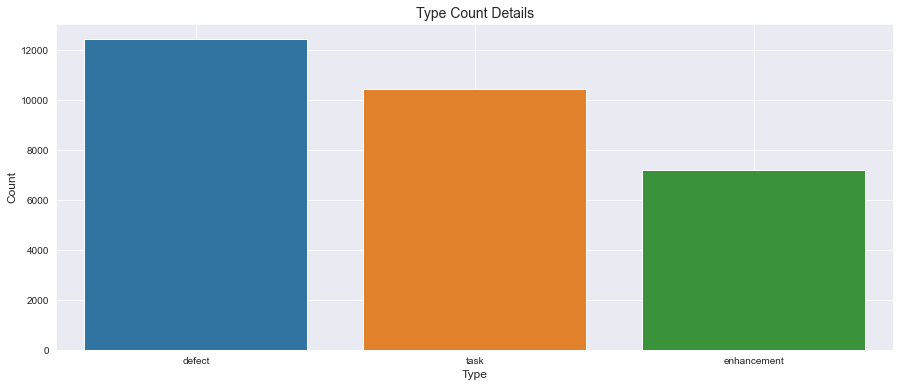

In [17]:
# Plotting Type to get a clear picture of the breakup
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Type'],ax=ax)
plt.title("Type Count Details", size = 14)
plt.xlabel("Type", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=0)
plt.grid()
plt.show()

In [59]:
print ('No. of unique Reporter Real Name values',len(data['Reporter Real Name'].unique()) )
# Reporter Real Name - There are 2184 distinct bug reporters in this dataset. 

No. of unique Reporter Real Name values 2184


In [60]:
print('No. of bugs without Reporter Real Name ',data['Reporter Real Name'].isna().sum()) # 1118 bugs have no value present for Reporter Real Name
# However we don't have any mapping based on Reporter Name. Also there are multiple cases with Null values. 
# So we will exclude this attribute from our list of features used for building the model

No. of bugs without Reporter Real Name  1118


In [19]:
data.Product.unique() #Product - Checking products have their bugs reported in the dataset

array(['Firefox', 'Release Engineering', 'Taskcluster', 'NSS', 'DevTools',
       'Data Science', 'Developer Services', 'Tree Management', 'Core',
       'Firefox Build System', 'Conduit', 'Infrastructure & Operations',
       'Toolkit', 'Thunderbird', 'Cloud Services', 'GeckoView',
       'SeaMonkey', 'bugzilla.mozilla.org', 'Testing', 'Bugzilla',
       'Web Compatibility', 'Webtools', 'WebExtensions', 'Calendar',
       'Data Platform and Tools', 'MailNews Core', 'Socorro', 'NSPR',
       'Shield', 'External Software Affecting Firefox', 'Firefox for iOS',
       'Remote Protocol', 'support.mozilla.org', 'Chat Core',
       'UX Systems', 'Localization Infrastructure and Tools',
       'User Research', 'developer.mozilla.org', 'addons.mozilla.org',
       'L20n', 'mozilla.org', 'Location', 'User Experience Design',
       'Product Innovation', 'Fenix', 'Mozilla Localizations', 'Tecken',
       'Developer Infrastructure', 'www.mozilla.org', 'Focus',
       'Participation Infrastructure

In [20]:
len(data.Product.unique()) #56 different products are present against which bugs are tagged

56

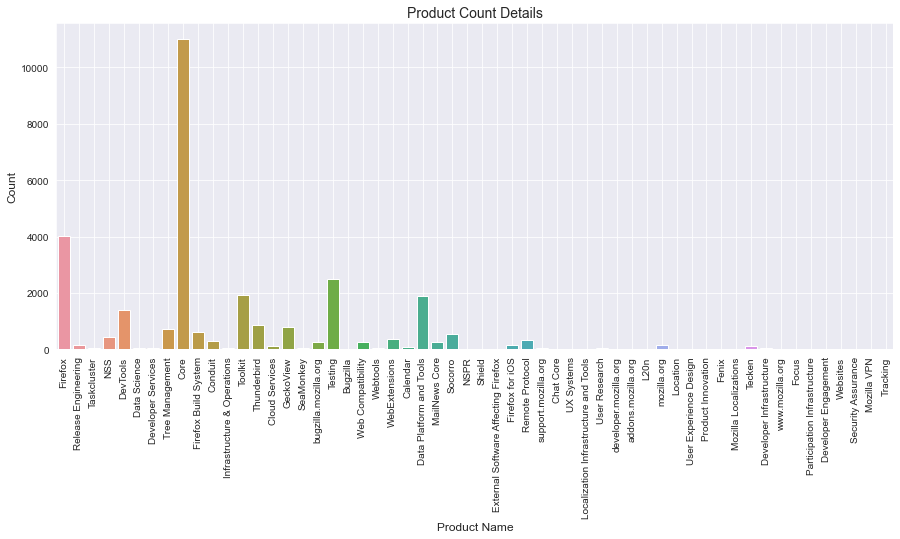

In [21]:
# Plotting Product to get a clear picture of the breakup. We see bugs are primarily reported for Core followed by Firefox
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Product'],ax=ax)
plt.title("Product Count Details", size = 14)
plt.xlabel("Product Name", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [22]:
data.Component.unique() # Component - Checking components against which bugs have been tagged

array(['General', 'Release Automation: Updates', 'Libraries', 'Debugger',
       'Dashboard', 'Mercurial: hg.mozilla.org',
       'Release Automation: L10N', 'Release Automation: Signing',
       'Treeherder', 'Firefox-CI Administration', 'Internationalization',
       'Lando', 'RelOps: Puppet', 'File Handling', 'Telemetry',
       'Treeherder: Infrastructure', 'Security: Process Sandboxing',
       'Build Config', 'Untriaged', 'Operations: Kinto', 'New Tab Page',
       'Operations: AMO', 'Android Studio and Gradle Integration',
       'Audio/Video: cubeb', 'Source Code Analysis',
       'Testing Infrastructure', 'Sandboxing', 'Form Autofill',
       'JavaScript Engine', 'Release Engineering',
       'Startup and Profile System', 'Operations and Service Requests',
       'RelOps: Hardware', 'Firefox Monitor', 'Fuzzing',
       'Audio/Video: Playback', 'Application Update',
       'Operations: Product Delivery', 'geckodriver', 'Security',
       'Email Notifications', 'Services', 'CA C

In [73]:
print('No. of unique Components ',len(data.Component.unique())) # There are 536 unique components against which bugs are tagged

No. of unique Components  536


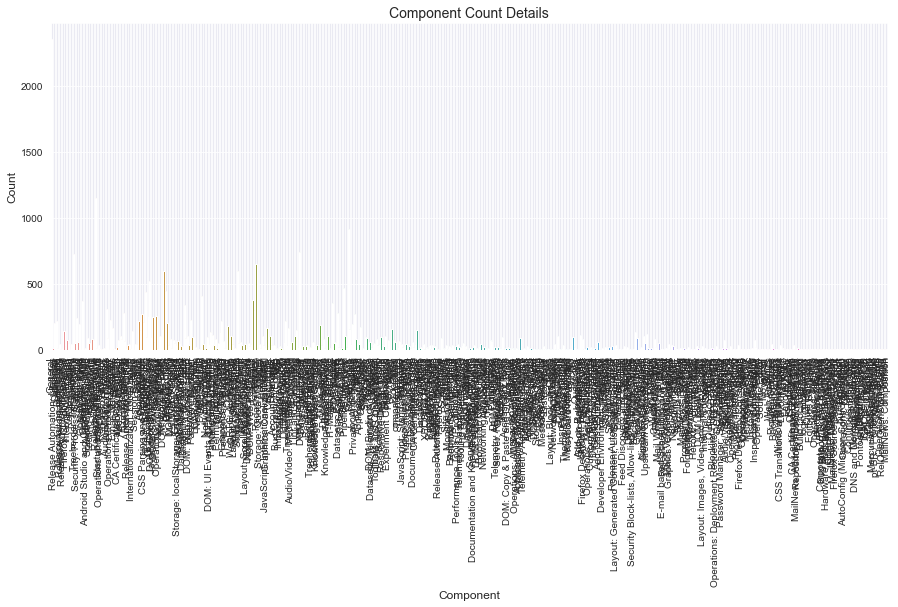

In [24]:
# Plotting Component to get a clear picture of the breakup. We see bugs are primarily reported General component category
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Component'],ax=ax)
plt.title("Component Count Details", size = 14)
plt.xlabel("Component", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [63]:
Count = data.groupby(by='Component')['Bug ID'].count().sort_values(ascending=False) # Mapping Component with number of tickets resolved by each
print(Count) #Component General followed by Javascript engine are the most used for bug tagging

Component
General                   2356
JavaScript Engine         1150
Glean: SDK                 917
web-platform-tests         740
Telemetry                  724
                          ... 
UI                           1
Server: Shavar               1
Flash (Adobe)                1
Server: Sync                 1
Mercurial: firefoxtree       1
Name: Bug ID, Length: 536, dtype: int64


In [26]:
data.Assignee.unique() #Assignee - Checking list of assignees who went on to resolve the bugs

array(['dothayer', 'nrthomas', 'wcosta', 'jc', 'loganfsmyth',
       'mmccorquodale', 'apop', 'nobody', 'jlorenzo', 'cameron', 'zibi',
       'ahal', 'ckolos', 'dhouse', 'aryx.bugmail', 'mdroettboom',
       'sclements', 'jld', 'rob', 'jeremy.orem', 'andrei.br92',
       'mpillard', 'nalexander', 'l10n', 'cchang', 'bpostelnicu',
       'jorgk-bmo', 'gbrown', 'jdemooij', 'ewong', 'dtownsend',
       'coopcoopbware', 'mcornmesser', 'jya-moz', 'ato', 'mozilla',
       'frgrahl', 'kwilson', 'masayuki', 'djmitche', 'agi', 'ryanvm',
       'mh+mozilla', 'rthijssen', 'peterv', 'tom', 'matt.woodrow',
       'dylan', 'dkl', 'tomica', 'acreskey', 'franziskuskiefer',
       'davidp99', 'bugzilla', 'jcoppeard', 'iireland', 'allstars.chh',
       'mgaudet', 'jimb', 'jorendorff', 'kvijayan', 'dlee', 'pbone',
       'sotaro.ikeda.g', 'haftandilian', 'jseward', 'valentin.gosu',
       'jmuizelaar', 'bobm', 'khyperia', 'nicolas.b.pierron', 'gps',
       'hsivonen', 'daniel', 'andrebargull', 'lhansen', 

In [61]:
print('No. of unique Assignee ',len(data.Assignee.unique())) # There are 948 unique assignee's who went on to resolve the bugs

No. of unique Assignee  948


In [28]:
Count = data.groupby(by='Assignee')['Bug ID'].count().sort_values(ascending=False) # Mapping Assignee with number of tickets resolved by each

In [29]:
print(Count) #There are 2593 instances where Assignee name is missing and marked as 'nobody'

Assignee
nobody           2593
wptsync          1961
willkg            635
jrediger          525
hskupin           477
                 ... 
hanyong.park        1
helenaenred         1
hemanth.hm          1
pmo                 1
77ganesh.nitt       1
Name: Bug ID, Length: 948, dtype: int64


In [30]:
# 8.64% bugs do not have an assignee tagged
print("Number of Incidents with no assignee", len(data[data.Assignee=='nobody']['Bug ID'].unique()))
print(f"Percentage of Incidents with no assignee {len(data[data.Assignee=='nobody']['Bug ID'].unique())/len(data['Bug ID'].unique())*100} %")

Number of Incidents with no assignee 2593
Percentage of Incidents with no assignee 8.643333333333333 %


#### Since our dataset consists of only 30000 records, so 8.64% records with no assignee is a significant count. We will revisit this later

In [31]:
data.Status.unique() #Status - All records are Resolved.So this attribute is not useful for our use case

array(['RESOLVED'], dtype=object)

In [33]:
data.Resolution.unique() # Resolution - 3 static values of either Fixed, Invalid or Worksforme which would mean bug couldnt be recreated
# Bugs once raised will be initially in Active status. So values corresponding to FIXED/INVALID/WORKSFORME are not relevant for model building.
# Hence the attribute Resolution can be discarded during model building.

array(['FIXED', 'INVALID', 'WORKSFORME'], dtype=object)

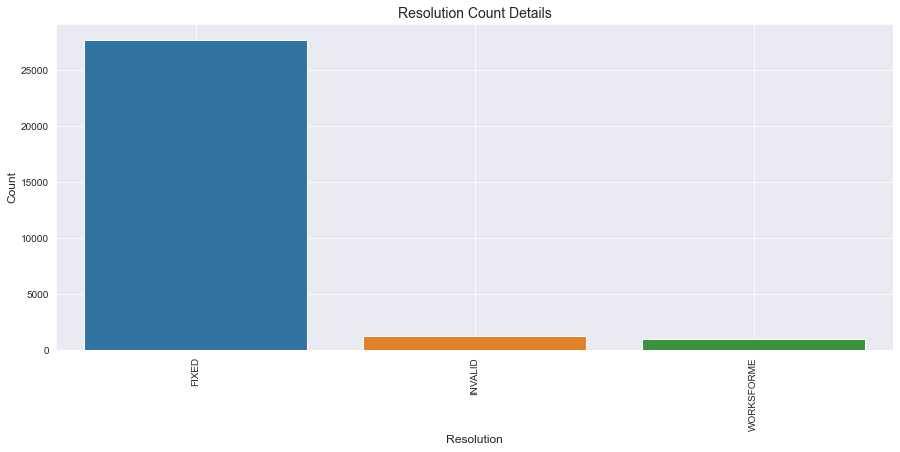

In [34]:
# Plotting Resolution to get a breakup. We see bugs are primarily marked as Fixed
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Resolution'],ax=ax)
plt.title("Resolution Count Details", size = 14)
plt.xlabel("Resolution", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [35]:
data.Priority.unique() #Priority - Categorized in 6 priorities  P1, P2, P3, P4, P5 and '--'

array(['P1', 'P2', 'P3', 'P4', 'P5', ' --'], dtype=object)

In [36]:
# Nearly 15.5% bugs donot have the priority defined. All are marked as ' --'. This is a significant amount considering the size of dataset
print("Number of Incidents with no defined priority i.e. --", len(data[data.Priority==' --']['Bug ID'].unique()))
print(f"Percentage of Incidents with no defined priority i.e. -- {len(data[data.Priority==' --']['Bug ID'].unique())/len(data['Bug ID'].unique())*100} %")

Number of Incidents with no defined priority i.e. -- 4643
Percentage of Incidents with no defined priority i.e. -- 15.476666666666667 %


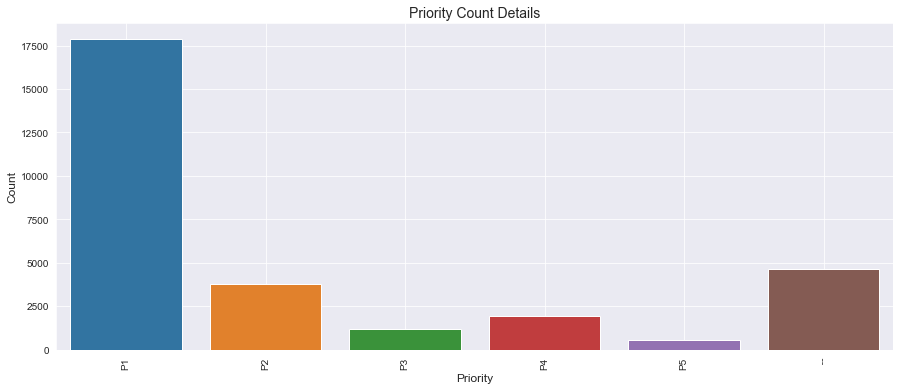

In [37]:
# Plotting Priority to get a breakup. We see bugs are primarily marked as P1. 2nd is the one with no priority tagged.
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Priority'],ax=ax)
plt.title("Priority Count Details", size = 14)
plt.xlabel("Priority", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [38]:
data.Classification.unique() # Classification - 5 distinct values

array(['Client Software', 'Other', 'Components',
       'Developer Infrastructure', 'Server Software'], dtype=object)

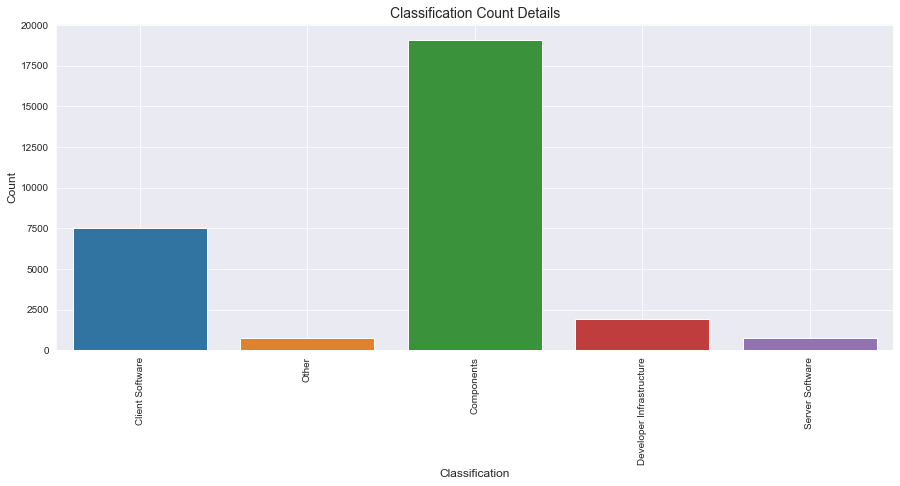

In [39]:
# Plotting Classification to get a breakup. We see bugs are primarily tagged against classification of Components. 2nd is Client Software
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Classification'],ax=ax)
plt.title("Classification Count Details", size = 14)
plt.xlabel("Classification", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [40]:
print(data['Team Name'].unique()) #Team Name - Denotes the team which resolved the bug. There are a total of 31 teams.
print(len(data['Team Name'].unique()))

['Frontend' 'RelEng' 'Mozilla' 'Crypto' 'DevTools' 'Internationalization'
 'CI and Quality Tools' 'Telemetry' 'OS Integration' 'Other' 'Services'
 'Pocket and User Journey' 'Media' 'Mobile' 'Credential Management'
 'Javascript' 'Low Level' 'Desktop Integrations' 'Privacy Engineering'
 'Web Extensions' 'Search and New Tab' 'GFX' 'Performance' 'Layout'
 'DOM LWS' 'Networking' 'DOM Core' 'Accessibility' 'Security Engineering'
 'Bugzilla' 'Relops']
31


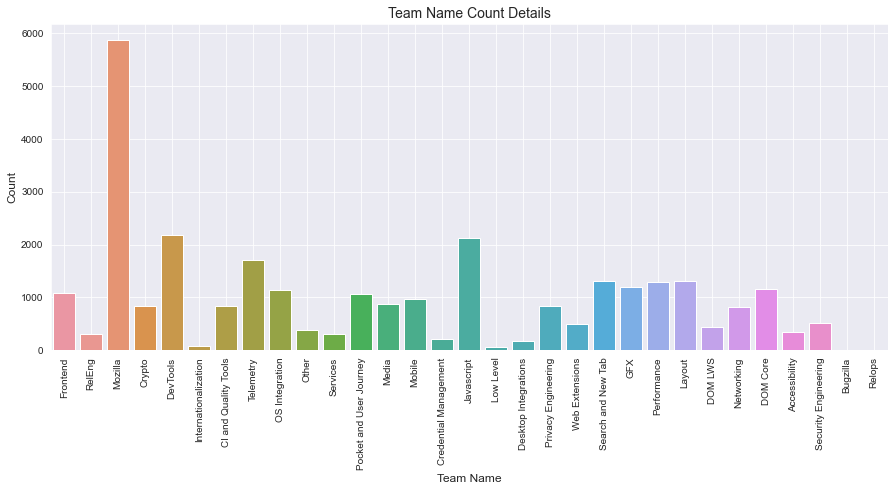

In [41]:
# Plotting Team Name to get a breakup. The Mozilla team resolved most of the issues followed by the DevTools and JavaScript teams
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Team Name'],ax=ax)
plt.title("Team Name Count Details", size = 14)
plt.xlabel("Team Name", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [42]:
#Breakup of resolution of bugs by different teams
count_team = data.groupby(by='Team Name')['Bug ID'].count().sort_values(ascending=False) # Mapping Team Name with number of tickets resolved by each Team
print(count_team)

Team Name
Mozilla                    5880
DevTools                   2174
Javascript                 2125
Telemetry                  1701
Search and New Tab         1321
Layout                     1310
Performance                1288
GFX                        1199
DOM Core                   1153
OS Integration             1139
Frontend                   1090
Pocket and User Journey    1059
Mobile                      980
Media                       884
Privacy Engineering         837
CI and Quality Tools        836
Crypto                      834
Networking                  826
Security Engineering        509
Web Extensions              500
DOM LWS                     450
Other                       393
Accessibility               351
Services                    314
RelEng                      302
Credential Management       222
Desktop Integrations        171
Internationalization         74
Low Level                    70
Bugzilla                      7
Relops                        

In [43]:
data['Filed via'].unique() #Filed via - 5 different modes were used to log the bugs

array(['unknown', 'api', 'standard_form', 'guided_form', 'custom_form'],
      dtype=object)

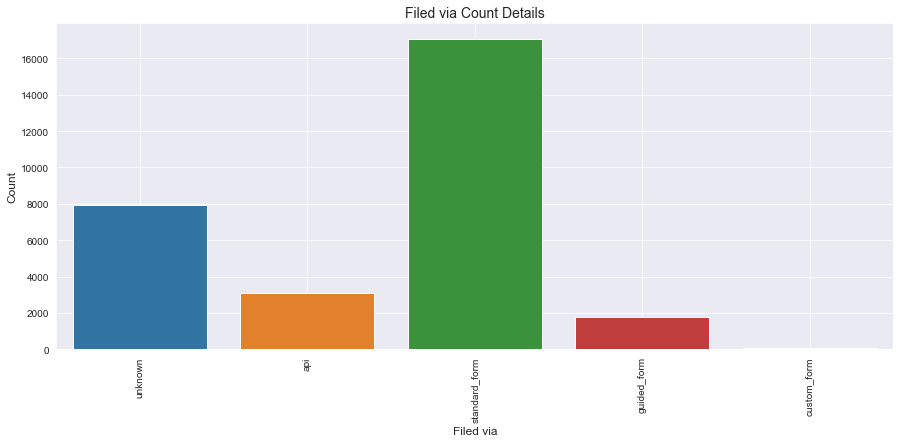

In [44]:
# Plotting Filed via to get a breakup. Bugs primarily filed via standard form. However a significant amount is marked as Unknown meaning the field was not captured.
fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(data['Filed via'],ax=ax)
plt.title("Filed via Count Details", size = 14)
plt.xlabel("Filed via", size=12)
plt.ylabel("Count", size=12)
plt.xticks(rotation=90)
plt.grid()
plt.show()

#### Based on our use case, we were initially planning to build a model to predict Assignee corresponding to a particular ticket. However, the number of distinct Assignees in the dataset is large (948) and about 9% does not contain relevant information (i.e. no agent assigned). Owing to lack of knowledge on the overall dataset in terms of Assignee details, and how they are actually mapped and assigned the tickets (and also due to large number of cases where Assignee details are not even present), we will not use Assignee as a Target variable. Infact, for model building we will not use the Assignee attribute at all and will drop it from the dataset. Instead we will maintain a list of Assignees for our use case (Organizations will have their own list and logic) which can be tagged based on the business logic developed on top of the predictions done by the model.
#### Hence we will experiment on few other target attributes. Team Name seems to be a good choice since if we are able to build a model to predict the correct Team Name, internally some business logic may be developed later to assign to a particular person (Support Executive) on the team. Component and Classification seem to be promising as a business logic may developed based on the same to determine routing to an actual Support Executive based on the same.
#### We will try to experiment with Team Name, Component and Classification and try to figure out the performance of each model (based on the limited data at our disposal) and accordingly determine which models are to be used for which Target variables to finally use for prediction.
#### Based on the initial data analysis above, there are few attributes (Bug ID, Reporter Real Name, Assignee, Status, Resolution) which we can drop as they will not have an impact on the model. We will do so in the next step and create the updated dataset which will be used for creating the models as part of our experiments.

#### We will initially treat the problem as a multilabel classification problem and use 2 simple approaches to start with:
##### 1. Multinomial Naive Bayes (MNB)
##### 2. Support Vector Machines (SVM)
#### After evaluation of these initial models, we will also try out few other algorithms 
#### 3. Logistic Regression
#### 4. Neural Network (involving MLP)  to determine if results are better. 

#### We will also predict our target variables (e.g. Team Name, Component and Classification) based on the results and classification reports that we see from the experiments.

In [46]:
f=pd.read_csv("./dataset/mozilla_bugs_final.csv")
keep_col = [ 'Type', 'Summary', 'Product',
       'Component', 'Priority',
       'Classification', 'Team Name']
new_f = f[keep_col]
new_f.to_csv("./dataset/mozilla_bugs.csv", index=False)